Fetching COPOM statements from BCB API...
  Fetching meeting 255... OK (8 paragraphs)
OK (8 paragraphs)
  Fetching meeting 256...   Fetching meeting 256... OK (10 paragraphs)
OK (10 paragraphs)
  Fetching meeting 257...   Fetching meeting 257... OK (10 paragraphs)
OK (10 paragraphs)
  Fetching meeting 258...   Fetching meeting 258... OK (11 paragraphs)
OK (11 paragraphs)
  Fetching meeting 259...   Fetching meeting 259... OK (11 paragraphs)
OK (11 paragraphs)
  Fetching meeting 260...   Fetching meeting 260... OK (11 paragraphs)
OK (11 paragraphs)
  Fetching meeting 261...   Fetching meeting 261... OK (12 paragraphs)
OK (12 paragraphs)
  Fetching meeting 262...   Fetching meeting 262... OK (11 paragraphs)
OK (11 paragraphs)
  Fetching meeting 263...   Fetching meeting 263... OK (11 paragraphs)
OK (11 paragraphs)
  Fetching meeting 264...   Fetching meeting 264... OK (12 paragraphs)
OK (12 paragraphs)
  Fetching meeting 265...   Fetching meeting 265... OK (10 paragraphs)
OK (10 paragrap

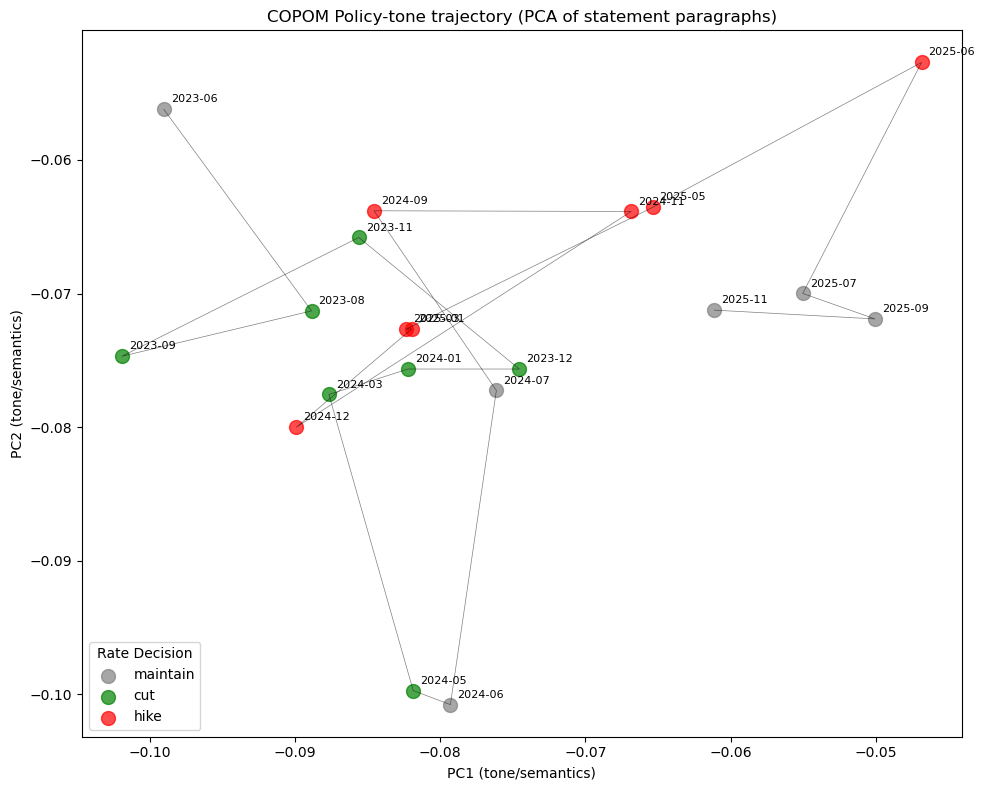

In [ ]:
# Minimal COPOM/FOMC tone trajectory with PCA
import pandas as pd
import html
import re
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time

# ---- 1) COPOM Data Retrieval Functions -------------------------------------------
def fetch_copom_comunicado(meeting_number):
    """Fetches COPOM statement (comunicado) for a specific meeting number."""
    def clean_html(raw_html):
        if not raw_html:
            return "", None
        decoded = html.unescape(raw_html)
        decoded = re.sub(r'[\u200b\ufeff\u00a0]', '', decoded)
        soup = BeautifulSoup(decoded, 'html.parser')
        
        # Remove tables
        for table in soup.find_all('table'):
            table.decompose()
        
        for br in soup.find_all('br'):
            br.replace_with('\n')
        for p in soup.find_all('p'):
            p.insert_after('\n\n')
        
        text = soup.get_text()
        text = re.sub(r'\n\s*\n', '\n\n', text)
        text = re.sub(r'[ \t]+', ' ', text)
        return text.strip()
    
    url = f"https://www.bcb.gov.br/api/servico/sitebcb/copom/comunicados_detalhes?nro_reuniao={meeting_number}"
    try:
        df_api = pd.read_json(url)
        content = df_api.iloc[0].iloc[0]
        
        meeting_num = content.get('nro_reuniao')
        date = content.get('dataReferencia')
        title = content.get('titulo')
        raw_text = content.get('textoComunicado')
        clean_text = clean_html(raw_text)
        
        return {
            'meeting_number': meeting_num,
            'date': pd.to_datetime(date),
            'title': title,
            'full_text': clean_text
        }
    except Exception as e:
        print(f"Error fetching meeting {meeting_number}: {e}")
        return None

# ---- 2) Build Dataset from COPOM API ---------------------------------------------
print("Fetching COPOM statements from BCB API...")
meetings_data = []
paragraphs_data = []

# Fetch last 20 meetings (adjust range as needed)
for meeting_num in range(255, 275):
    print(f"  Fetching meeting {meeting_num}...", end=" ")
    result = fetch_copom_comunicado(meeting_num)
    if result:
        meetings_data.append(result)
        # Split into paragraphs
        paras = [p.strip() for p in result['full_text'].split('\n\n') if p.strip() and len(p.strip()) > 50]
        for i, para in enumerate(paras):
            paragraphs_data.append({
                'date': result['date'],
                'meeting_id': result['meeting_number'],
                'paragraph_id': i,
                'text': para,
                'rate_decision': 'maintain' if 'mantém' in result['title'].lower() else 
                                 ('hike' if 'eleva' in result['title'].lower() else 'cut')
            })
        print(f"OK ({len(paras)} paragraphs)")
    else:
        print("FAILED")
    time.sleep(0.3)  # Be nice to the API

df = pd.DataFrame(paragraphs_data)
print(f"\nTotal paragraphs: {len(df)}")
print(f"Meetings: {df['meeting_id'].nunique()}")
print(df.head())

# ---- 3) Vectorize paragraphs (bag-of-words baseline; swap to embeddings later)
tfidf = TfidfVectorizer(min_df=3, max_df=0.8, ngram_range=(1,2))
X = tfidf.fit_transform(df["text"])

# ---- 4) Dimensionality reduction (PCA) ---------------------------------------
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X.toarray())
df["x"], df["y"] = Z[:,0], Z[:,1]

# ---- 5) Aggregate per meeting (median is robust) -----------------------------
traj = (df.groupby(["meeting_id","date","rate_decision"], as_index=False)
          .agg(x=("x","median"), y=("y","median"))).sort_values("date")

# ---- 6) Plot the policy trajectory ------------------------------------------
plt.figure(figsize=(10,8))

# Color by rate decision
colors = {'hike': 'red', 'maintain': 'gray', 'cut': 'green'}
for decision in traj['rate_decision'].unique():
    subset = traj[traj['rate_decision'] == decision]
    plt.scatter(subset['x'], subset['y'], c=colors.get(decision, 'blue'), 
                label=decision, s=100, alpha=0.7)

# Draw trajectory line
plt.plot(traj["x"], traj["y"], 'k-', linewidth=0.5, alpha=0.5)

# Add date labels
for i, row in traj.iterrows():
    plt.annotate(row["date"].strftime("%Y-%m"), (row["x"], row["y"]), 
                 fontsize=8, xytext=(5, 5), textcoords='offset points')

plt.title("COPOM Policy-tone trajectory (PCA of statement paragraphs)")
plt.xlabel("PC1 (tone/semantics)")
plt.ylabel("PC2 (tone/semantics)")
plt.legend(title="Rate Decision")
plt.tight_layout()
plt.show()